- **Date:** 2019-5-22
- **Author:** Zhanyuan Zhang
- **Purpose:** 
    - This notebook trys to debug the prediction in the BagNet-33.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from bagnets.utils import plot_heatmap, generate_heatmap_pytorch
from bagnets.utils import pad_image, convert2channel_last, imagenet_preprocess, extract_patches, bagnet_predict, compare_heatmap
from foolbox.utils import samples
import bagnets.pytorch
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import numpy as np
import time
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
if use_cuda:
    print(torch.cuda.get_device_name(0))

Tesla K80


In [3]:
# load pretrained model
pytorch_model = bagnets.pytorch.bagnet33(pretrained=True).to(device)

Sidenote: Go to *foolbox.\__file__/data* to check all the samples image provided by foolbox.

### 0. Define some helper functions

In [4]:
def class_patch_logits(bagnet, patches, device, batch_size=1000, num_classes=1000):
    """ Obtain the logits of all the classes across all the patches
    """
    logits_list = []
    with torch.no_grad():
        for batch_patches in torch.split(patches, batch_size):
            logits = bagnet(batch_patches)
            for i in range(num_classes):
                class_logits = logits[:, i]
                logits_list.append(class_logits.data.cpu().numpy().copy())
    return np.hstack(logits_list)

### 1. Check the distribution of logits across all the classes and patches.

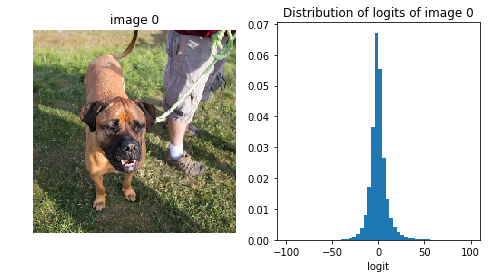

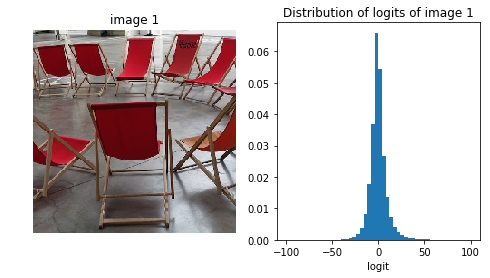

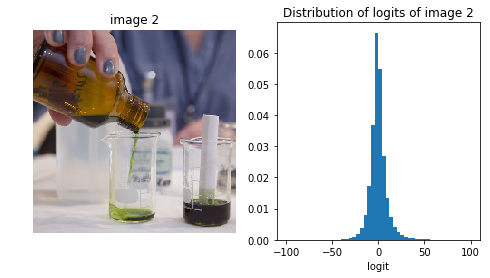

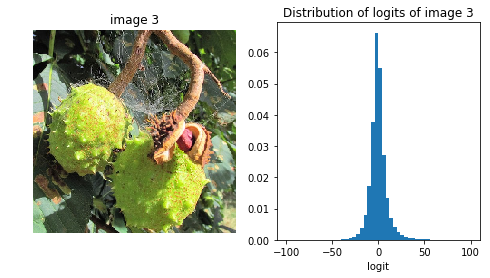

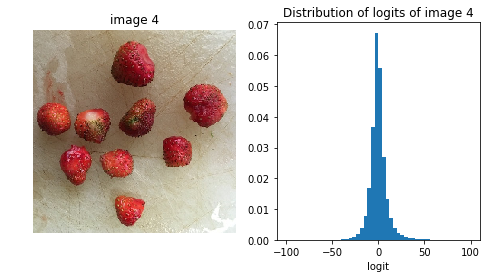

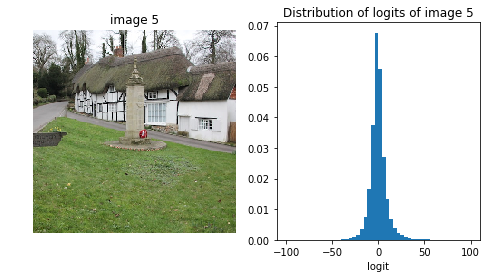

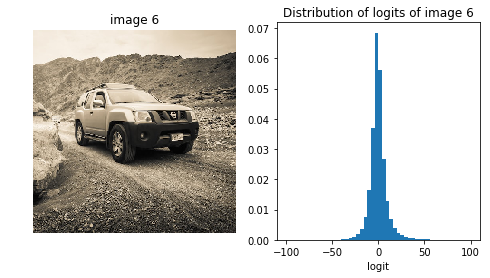

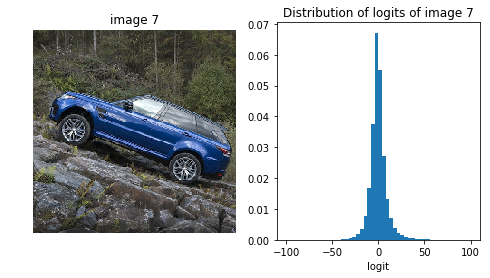

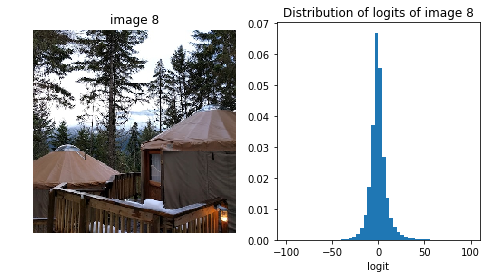

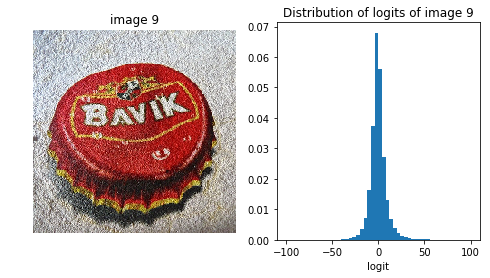

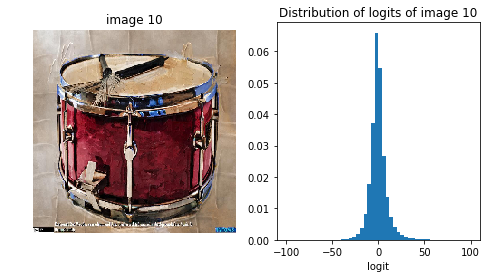

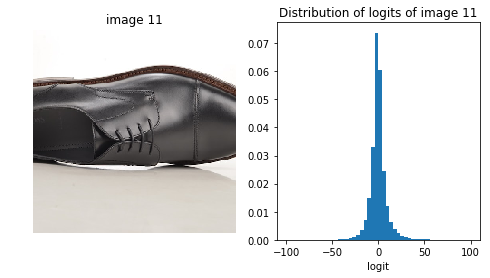

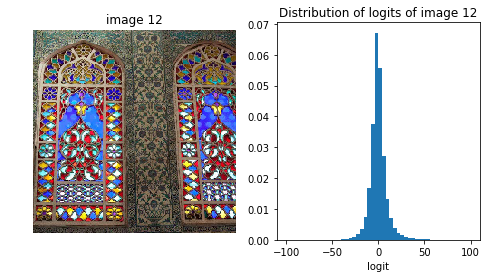

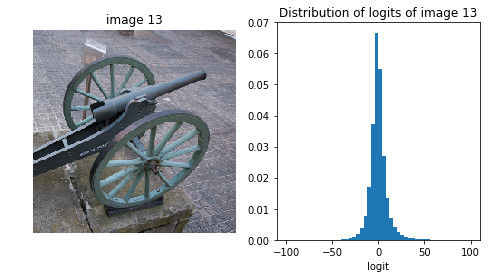

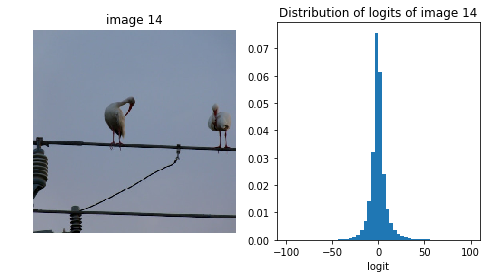

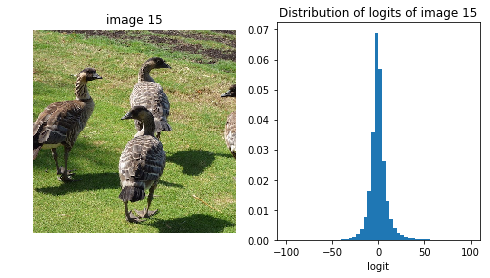

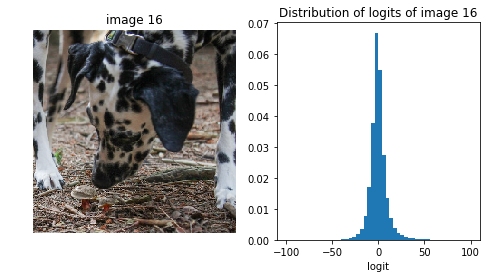

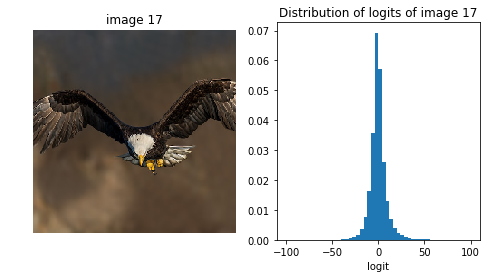

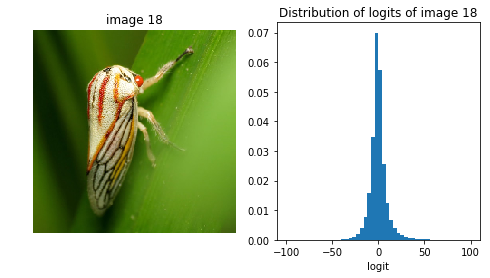

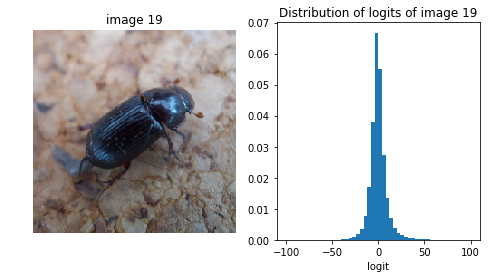

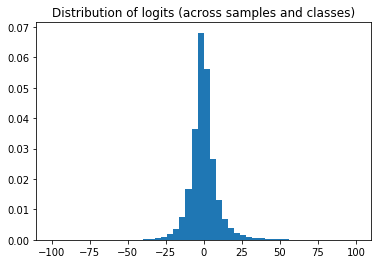

In [5]:
patchsize = 33
np.random.seed(42)
all_logits = np.array([])
for idx in range(20):
    fig = plt.figure(figsize=(8, 4))
    # Display the sampled image
    image, label = samples(dataset='imagenet', index=idx, batchsize=1, shape=(224, 224), data_format='channels_first')
    original_image = convert2channel_last(image[0])
    ax = plt.subplot(121)
    ax.set_title('image {}'.format(idx))
    plt.imshow(original_image/255.0)
    plt.axis('off')
    
    # Preprocess the sampled image and plot the histogram
    sample = imagenet_preprocess(image)
    padded_sample = pad_image(sample, patchsize)
    input = torch.from_numpy(padded_sample).to(device)
    patches = extract_patches(input, patchsize)
    logits = class_patch_logits(pytorch_model, patches, device)
    all_logits = np.concatenate((all_logits, logits))
    ax = plt.subplot(122)
    ax.set_title('Distribution of logits of image {}'.format(idx))
    n, bins, patches = plt.hist(logits, bins = 50, range = (-100, 100), density=True)
    ax.set_xlabel('logit')
    plt.show()

n, bins, patches = plt.hist(all_logits, bins = 50, range = (-100, 100), density=True)
plt.title('Distribution of logits (across samples and classes)')
plt.show()